# Tutorial 3. MNIST

In this tutorial, we will show you how to train an actual CNN model, albeit small. We will be using the old good MNIST dataset and the LeNet model, with a slight change that the sigmoid activations are replaced with ReLUs.

TODO: write key points to observe in this tutorial.

We will use the cnn model helper - that helps us to deal with parameter initializations naturally.

First, let's import the necessities.

In [1]:
# First, let's import a few stuff.
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os

from caffe2.python import core, cnn, net_drawer, workspace, visualize

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])

# We will exhibit how to write statistics during the training time to local disks, so we will
# set up a root folder for us to write statistics into.
data_folder = os.path.join(os.path.expanduser('~'), 'python', 'tutorial_data')
root_folder = os.path.join(os.path.expanduser('~'), 'python', 'tutorial_files', 'tutorial_3_mnist')
workspace.ResetWorkspace(root_folder)

True

We will be using the CNNModelHelper, which has a set of wrapper functions that automatically separates the parameter intialization and the actual computation into two networks. Under the hood, a CNNModelHelper object has two underlying nets, param_init_net and net, that keeps record of the initialization network and the main network respectively.

In [12]:
# For the sake of modularity, we will separate the model to multiple different parts:
# (1) The data input part
# (2) The main computation part
# (3) The training part - adding gradient operators, update, etc.
# (4) The bookkeeping part, where we just print out statistics for inspection.

def AddInput(model, batch_size, db, db_type):
    """Adds the data input part."""
    # Load the data from a DB. Now, we store MNIST data in pixel values, so after
    # batching, this will give us data with shape [batch_size, 1, 28, 28] of data
    # type uint8, and label with shape [batch_size,] of data type int.
    data_uint8, label = model.TensorProtosDBInput(
        [], ["data_uint8", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    # Since we are going to do float computations, what we will do is to cast the
    # data to float.
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # For better numerical stability, instead of representing data in [0, 255] range
    # we will scale them down to [0, 1]. Note that we are doing in-place computation
    # for this operator: we don't need the pre-scale data.
    data = model.Scale(data, data, scale=float(1./256))
    # Now, when computing the backward pass, we will not need the gradient computation
    # for the backward pass. StopGradient does exactly that: in the forward pass it
    # does nothing and in the backward pass all it does is to tell the gradient
    # generator "the gradient does not need to pass through me".
    data = model.StopGradient(data, data)
    return data, label


def AddLeNetModel(model, data):
    """Adds the main LeNet model.
    
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer change
    image size. For example, kernel of size 5 reduces each side of an image by 4. 
    
    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it devides
    each side in half. 
    """
    # Image size: 28 x 28 -> 24 x 24
    conv1 = model.Conv(data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = model.MaxPool(conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = model.Conv(pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = model.MaxPool(conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    fc3 = model.FC(pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    fc3 = model.Relu(fc3, fc3)
    pred = model.FC(fc3, 'pred', 500, 10)
    softmax = model.Softmax(pred, 'softmax')
    return softmax

def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = model.Accuracy([softmax, label], "accuracy")
    return accuracy

def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, "loss")
    # For bookkeeping purposes, we will also compute the accuracy of the model.
    AddAccuracy(model, softmax, label)
    # Now, this is the key part of the training model: we add all the gradient
    # operators to the model. The gradient is computed with respect to the loss
    # that we computed above.
    model.AddGradientOperators([loss])
    # Now, here what we will do is a very simple stochastic gradient descent.
    # TODO(jiayq): We are working on wrapping these SGD operations in a cleaner
    # fashion, and we will update this when it is ready. For now, you can see
    # how we basically express the SGD algorithms with basic operators.
    ITER = model.Iter("iter")
    # We do a simple learning rate schedule where lr = base_lr * (t ^ gamma)
    # Note that we are doing minimization, so the base_lr is negative so we are
    # going the DOWNHILL direction.
    LR = model.LearningRate(
        ITER, "LR", base_lr=-0.1, policy="step", stepsize=1, gamma=0.999 )
    # ONE is a constant value that is used in the gradient update. We only need
    # to create it once, so it is explicitly placed in param_init_net.
    ONE = model.param_init_net.ConstantFill([], "ONE", shape=[1], value=1.0)
    # Now, for each parameter, we do the gradient updates.
    for param in model.params:
        # Note how we get the gradient of each parameter - CNNModelHelper keeps
        # track of that.
        param_grad = model.param_to_grad[param]
        # The update is a simple weighted sum: param = param + param_grad * LR
        model.WeightedSum([param, ONE, param_grad, LR], param)
    # Of course, we will need to checkpoint the parameters of the model periodically.
    # This is achieved via the Checkpoint operator. It also takes in a parameter
    # "every" so that we don't checkpoint way too often. In this case, we will say
    # let's checkpoint every 20 iterations, which should probably be fine.
    model.Checkpoint([ITER] + model.params, [],
                   db="mnist_lenet_checkpoint_%05d.minidb",
                   db_type="minidb", every=20)
    
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be very verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.

Now, let's actually create the models for training and testing. If you are seeing WARNING messages below, don't be alarmed - 

In [3]:
# Training model. We will basically need every piece of the components
# we defined above.
# We will use the plain-old NCHW storage order for this model.
train_model = cnn.CNNModelHelper(order="NCHW", name="mnist_train")
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist/mnist-train-nchw-minidb'),
    db_type='minidb')
softmax = AddLeNetModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
AddBookkeepingOperators(train_model)

# Testing model. We will set the batch size to 100, so that the testing
# pass is 100 iterations (10,000 images in total).
# For the testing model, we need the data input part, the main LeNetModel
# part, and an accuracy part. Note that init_params is set False because
# we will be using the parameters obtained from the train model.
test_model = cnn.CNNModelHelper(
    order="NCHW", name="mnist_test", init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist/mnist-test-nchw-minidb'),
    db_type='minidb')
softmax = AddLeNetModel(test_model, data)
AddAccuracy(test_model, softmax, label)

# Deployment model. We simply need the main LeNetModel part.
deploy_model = cnn.CNNModelHelper(
    order="NCHW", name="mnist_deploy", init_params=False)
AddLeNetModel(deploy_model, "data")
# You may wonder what happens with the param_init_net part of the deploy_model.
# No, we will not use them, since during deployment time we will not randomly
# initialize the parameters, but load the parameters from the db.

print('Created training and deploy models.')

Created training and deploy models.


Now, let's take a look what the training and deploy models look like, using the simple graph visualization tool that Caffe2 has. If the following command fails for you, it might be because that the machine you run on does not have graphviz installed. You can usually install that by

```sudo yum install graphviz```

If the graph looks too small, right click and open the image in a new tab for better inspection.

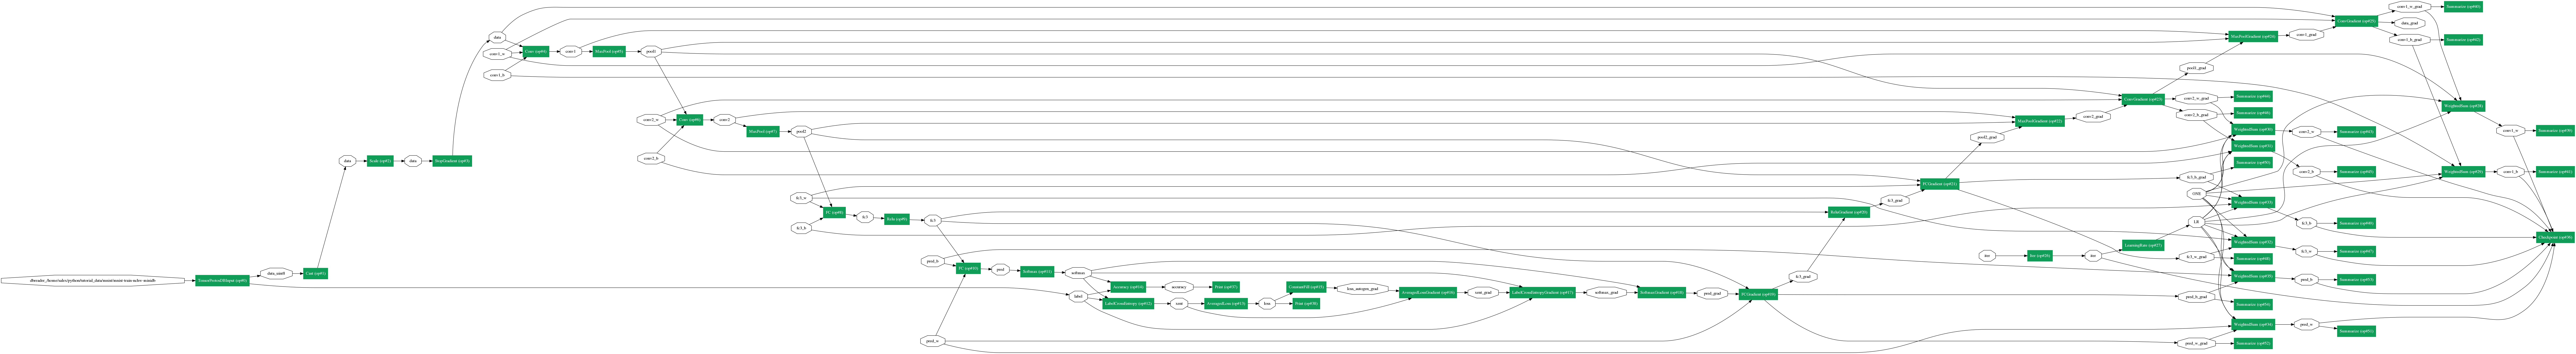

In [4]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

Now, the graph above shows everything that is happening in the training phase: the white nodes are the blobs, and the green rectangular nodes are the operators being run. You may have noticed the massive parallel lines like train tracks: these are dependencies from the blobs generated in the forward pass to their backward operators.

Let's display the graph in a more minimal way by showing only the necessary dependencies and only showing the operators. If you read carefully, you can see that the left half of the graph is the forward pass, the right half of the graph is the backward pass, and on the very right there are a set of parameter update and summarization operators.

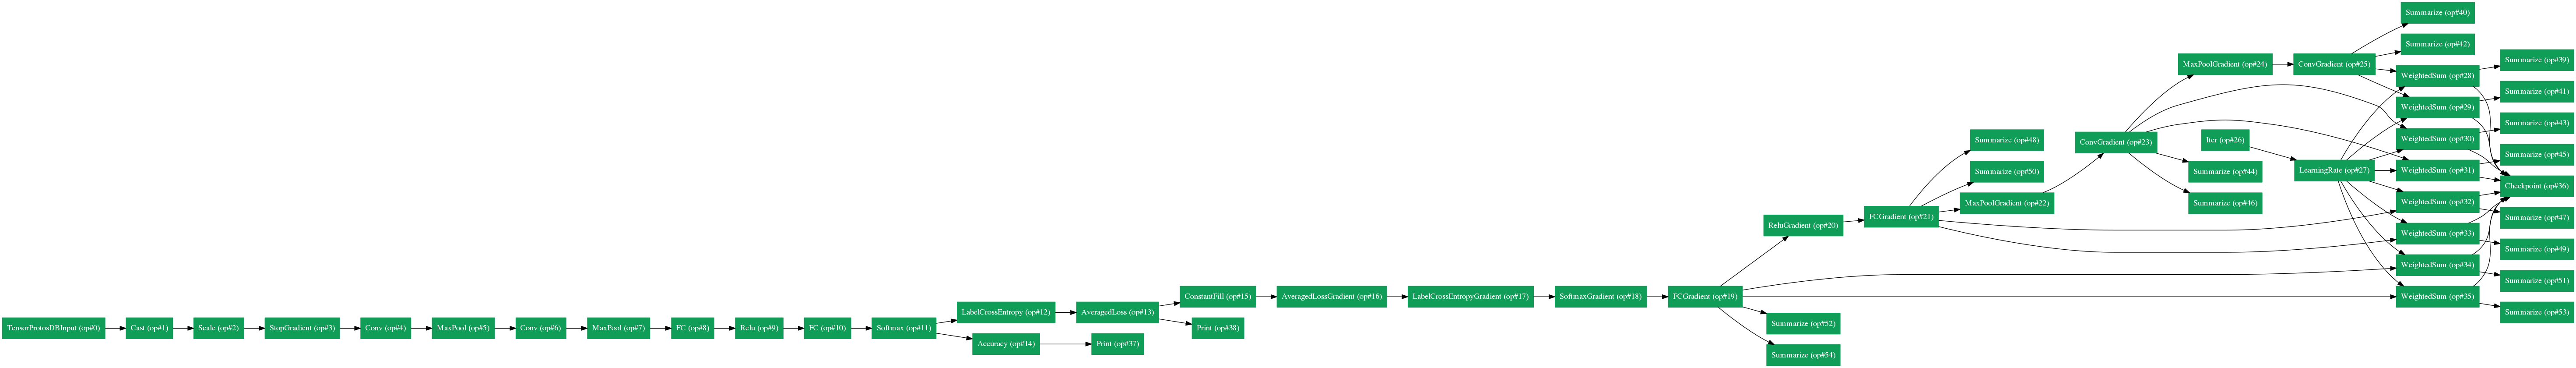

In [5]:
graph = net_drawer.GetPydotGraphMinimal(
    train_model.net.Proto().op, "mnist", rankdir="LR", minimal_dependency=True)
display.Image(graph.create_png(), width=800)

Now, when we run the network, one way is to directly run it from Python. Remember as we are running the network, we can periodically pull blobs from the network - Let's first show how we do this.

Before, that, let's re-iterate the fact that, the CNNModelHelper class has not executed anything yet. All it does is to *declare* the network, which is basically creating the protocol buffers. For example, we will show a portion of the serialized protocol buffer for the training models' param init net.

In [6]:
print(str(train_model.param_init_net.Proto())[:400] + '\n...')

name: "mnist_train_init"
op {
  output: "dbreader_/home/salex/python/tutorial_data/mnist/mnist-train-nchw-minidb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "minidb"
  }
  arg {
    name: "db"
    s: "/home/salex/python/tutorial_data/mnist/mnist-train-nchw-minidb"
  }
}
op {
  output: "conv1_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 20
    ints: 1
...


In [7]:
# We will also dump all the protocol buffers to disk
# so you can easily inspect them. As you may have
# noticed, these protocol buffers are much like the old
# good caffe's network definitions.
with open(os.path.join(root_folder, "train_net.pbtxt"), 'w') as fid:
    fid.write(str(train_model.net.Proto()))
with open(os.path.join(root_folder, "train_init_net.pbtxt"), 'w') as fid:
    fid.write(str(train_model.param_init_net.Proto()))
with open(os.path.join(root_folder, "test_net.pbtxt"), 'w') as fid:
    fid.write(str(test_model.net.Proto()))
with open(os.path.join(root_folder, "test_init_net.pbtxt"), 'w') as fid:
    fid.write(str(test_model.param_init_net.Proto()))
with open(os.path.join(root_folder, "deploy_net.pbtxt"), 'w') as fid:
    fid.write(str(deploy_model.net.Proto()))

Now, let's run the training procedure. We will drive all the computation in Python here: you can also write a plan out to disk so that you can completely train stuff in C++, but we'll leave that for another day.

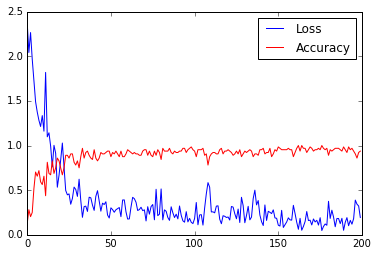

In [8]:
# The parameter initialization network only needs to be run once.
workspace.RunNetOnce(train_model.param_init_net)

# Now, since we are going to run the main network multiple times,
# we first create the network - which puts the actual network generated
# from the protobuf into the workspace - and then call RunNet by
# its name.
workspace.CreateNet(train_model.net)
# On the Python side, we will create two numpy arrays to record the accuracy
# and loss for each iteration.
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net.Proto().name)
    accuracy[i] = workspace.FetchBlob('accuracy')
    loss[i] = workspace.FetchBlob('loss')
# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

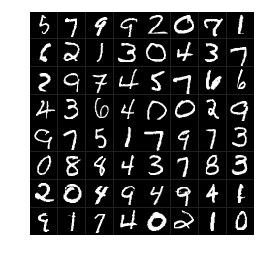

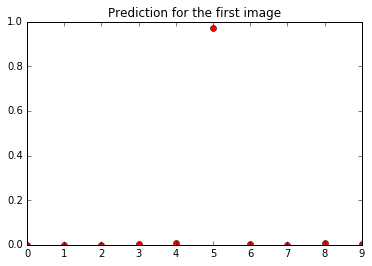

In [9]:
# Let's look at some of the data.
pyplot.figure()
data = workspace.FetchBlob('data')
_ = visualize.NCHW.ShowMultiple(data)
pyplot.figure()
softmax = workspace.FetchBlob('softmax')
_ = pyplot.plot(softmax[0], 'ro')
pyplot.title('Prediction for the first image')

test_accuracy: 0.950900


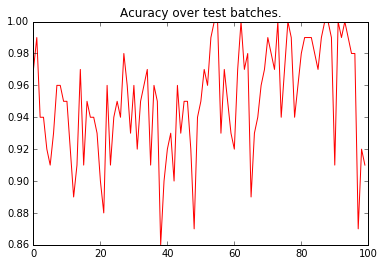

In [10]:
# Now, remember that we created the test net? We will run the test
# pass and report the test accuracy here.
# Note that although test_model will be using the parameters
# obtained from train_model, test_model.param_init_net must still
# be run to initialize the input data.
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net)
# On the Python side, we will create two numpy arrays to record the accuracy
# and loss for each iteration.
test_accuracy = np.zeros(100)
for i in range(100):
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy[i] = workspace.FetchBlob('accuracy')
# After the execution is done, let's plot the values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Acuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

In [11]:
workspace.blobs['conv1'].shape

(100, 20, 24, 24)